# Custom regions
**Use an updated plantations file to calculate the statistics for thresholds**


In [1]:
cd /g/data/xv83/rxm599/acs/plotting_maps/

/g/data/xv83/rxm599/acs/plotting_maps


In [2]:
# import needed packages
#from acs_area_statistics_rjm import acs_regional_stats, get_regions
from acs_area_statistics import acs_regional_stats, get_regions
import xarray as xr
import geopandas as gpd
from glob import glob
import pandas as pd
import regionmask
import matplotlib.pyplot as plt
import numpy as np


import dask

import cartopy.crs as ccrs

## Read in new mask and modify it

In [3]:
# Specify your own shapefile:
# new plantations file
regions_file = "/g/data/ia39/ncra/fire/plantations/Plantations2016_buffered_NPI_and_MUF.shp"
#regions_file = "/g/data/ia39/ncra/fire/plantations0/Plantations2016_buffered_NPI_and_Pilliga.shp"
#regions_file = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data/plantations/plantations.shp"
gdf = gpd.read_file(regions_file)
gdf
#print(gdf)
#print(gdf.Regn_06)
#print(gdf.index)
#print(gdf.REGCODE)

,Regn_06,NPI_Nam,PLANT_A,Regn_Nm,Group,geometry
0,1.0,Western Australia,383400.0,Western Australia,Western Australia,"MULTIPOLYGON (((-827149.568 -3727128.363, -827..."
1,2.0,Northern Territory,47600.0,Northern Territory,Northern Territory,"MULTIPOLYGON (((-173169.293 -1179401.088, -167..."
2,3.0,Mount Lofty Ranges and Kangaroo Island,33400.0,Mount Lofty Ranges and Kangaroo Island,South & East,"MULTIPOLYGON (((507041.848 -3899158.654, 50686..."
3,4.0,Green Triangle,336600.0,Green Triangle,South & East,"POLYGON ((790249.240 -3995031.530, 790834.200 ..."
4,5.0,Northern Queensland,73200.0,Northern Queensland,Northern Queensland,"MULTIPOLYGON (((1816076.884 -2542117.461, 1816..."
5,6.0,South East Queensland,191700.0,South East Queensland,South & East,"MULTIPOLYGON (((2082381.826 -3118313.228, 2082..."
6,7.0,Northern Tablelands,17400.0,Northern Tablelands,South & East,"MULTIPOLYGON (((1945931.363 -3241612.706, 1945..."
7,8.0,North Coast,94500.0,North Coast,South & East,"MULTIPOLYGON (((1964788.985 -3236942.798, 1966..."
8,9.0,Central Tablelands,86900.0,Central Tablelands,South & East,"MULTIPOLYGON (((1662284.711 -3698249.555, 1671..."
9,10.0,Southern Tablelands,22100.0,Southern Tablelands,South & East,"MULTIPOLYGON (((1662284.891 -3863664.121, 1669..."


In [4]:
# Rename column needed to make the masking code work
gdf.Regn_06=np.arange(0,len(gdf))

# you need to rename the "name" column and "abbrevs" column
# have a look at the table and see what makes sense, for example:
name_column = "CodeName"
abbr_column = "REGCODE"
name_column = "Regn_Nm"
abbr_column = "REGCODE"
name_column = "Regn_Nm"
abbr_column = "Regn_06"

# specify the name of the geopandas dataframe. any str
shapefile_name = "custom_regions"

# update the crs to lats and lons. Some original shapefiles will use northings etc 
gdf =gdf.to_crs(crs = "GDA2020")

# ensure the index has unique values from zero
gdf.index = np.arange(0, len(gdf))

regions= regionmask.from_geopandas(gdf,
                                   names=name_column, 
                                   abbrevs=abbr_column, 
                                   name=shapefile_name,
                                   overlap=True) 

regions

<regionmask.Regions 'custom_regions'>
overlap:  True

Regions:
 0  0                      Western Australia
 1  1                     Northern Territory
 2  2 Mount Lofty Ranges and Kangaroo Island
 3  3                         Green Triangle
 4  4                    Northern Queensland
.. ..                                    ...
12 12                      Central Gippsland
13 13                 East GippslandBombala
14 14                               Tasmania
15 15                                Pilliga
16 16                                 SE NSW

[17 regions]

## Apply mask information to the data

In [5]:
# get file of storing GWL change for each RCM
var = "100"
file = f"/g/data/ia39/ncra/fire/change_threshold_all_100.nc"
file1 = f"/g/data/ia39/ncra/fire/change_threshold_all_75.nc"
file2 = f"/g/data/ia39/ncra/fire/change_threshold_all_50.nc"

In [6]:
%%time
ds= xr.open_dataset( file )
ds1= xr.open_dataset( file1 )
ds2= xr.open_dataset( file2 )

CPU times: user 2.79 s, sys: 1.13 s, total: 3.92 s
Wall time: 5.54 s


In [7]:
# make your mask
# Fractional mask - weighted according to the proportion of the shapefile in partial grids using a value from 0 to 1
mask_frac = regions.mask_3D_frac_approx(ds)

# Centred mask. A boolean mask, True if the grid centre is within the shapefile region.
mask_centred = regions.mask_3D(ds)

<GeoAxes: >

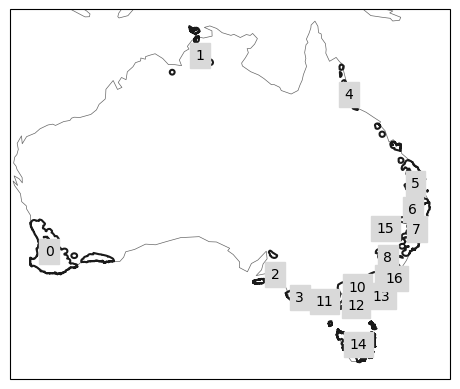

In [8]:
regions.plot()

## Apply mask to dataset

In [9]:
# List of periods and variables
periods = ['GW1p2', 'GW1p5', 'GW2p0', 'GW3p0', 'GW4p0']
print(ds.model)
#    print(m.values)

<xarray.DataArray 'model' (model: 12)> Size: 96B
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])
Coordinates:
  * model    (model) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11


In [10]:
%%time
# calculate the area averages for each region
dict_means = {}
var='days100'
df = acs_regional_stats(ds=ds, var=var,  mask=mask_frac, 
       dims = ( "lat", "lon",),  how = ["mean"])
df[f"{var}_mean"] = df[f"{var}_mean"].round(2)
var='days75'
df1 = acs_regional_stats(ds=ds1, var=var,  mask=mask_frac, 
       dims = ( "lat", "lon",),  how = ["mean"])
df1[f"{var}_mean"] = df1[f"{var}_mean"].round(2)
var='days50'
df2 = acs_regional_stats(ds=ds2, var=var,  mask=mask_frac, 
       dims = ( "lat", "lon",),  how = ["mean"])
df2[f"{var}_mean"] = df2[f"{var}_mean"].round(2)
df

CPU times: user 847 ms, sys: 601 ms, total: 1.45 s
Wall time: 1.46 s


<xarray.Dataset> Size: 10kB
Dimensions:       (model: 12, period: 4, region: 17)
Coordinates:
  * model         (model) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * period        (period) int64 32B 0 1 2 3
  * region        (region) int64 136B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    abbrevs       (region) int64 136B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    names         (region) <U38 3kB 'Western Australia' ... 'SE NSW'
Data variables:
    days100_mean  (model, period, region) float64 7kB 0.0 0.0 0.0 ... 0.03 0.0

In [11]:
df2

<xarray.Dataset> Size: 10kB
Dimensions:      (model: 12, period: 4, region: 17)
Coordinates:
  * model        (model) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * period       (period) int64 32B 0 1 2 3
  * region       (region) int64 136B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    abbrevs      (region) int64 136B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    names        (region) <U38 3kB 'Western Australia' ... 'SE NSW'
Data variables:
    days50_mean  (model, period, region) float64 7kB 0.0 0.0 0.0 ... 4.48 0.42

In [12]:
def rcm_stats(ds_means,outfile):
    ens_p50 = ds_means.quantile(0.5, dim="model").drop_vars("quantile")
    ens_p10 = ds_means.quantile(0.1, dim="model").drop_vars("quantile")
    ens_p90 = ds_means.quantile(0.9, dim="model").drop_vars("quantile")
    m1=ens_p50.rename('days100_p50').round(2)
    m0=ens_p10.rename('days100_p10').round(2)
    m2=ens_p90.rename('days100_p90').round(2)
    all=xr.merge([m0,m1,m2]) #,m2)
    m2d=all.to_dataframe()
    m2d.to_csv(outfile)
    return all


In [13]:
cd /g/data/xv83/rxm599/acs/hazard_fire

/g/data/xv83/rxm599/acs/hazard_fire


In [14]:
all=rcm_stats(df.days100_mean,'aplantations_ffdi_days100.csv')
all=rcm_stats(df1.days75_mean,'aplantations_ffdi_days75.csv')
all=rcm_stats(df2.days50_mean,'aplantations_ffdi_days50.csv')

In [15]:
all.to_dataframe()

abbrevs                                   names  days100_p10  \
period region                                                                 
0      0             0                       Western Australia         0.00   
       1             1                      Northern Territory         0.00   
       2             2  Mount Lofty Ranges and Kangaroo Island         0.00   
       3             3                          Green Triangle         0.00   
       4             4                     Northern Queensland         0.00   
...                ...                                     ...          ...   
3      12           12                       Central Gippsland         0.20   
       13           13                  East GippslandBombala         0.01   
       14           14                                Tasmania         0.00   
       15           15                                 Pilliga         1.86   
       16           16                                  SE NSW         0.01   

               days100_p50  days100_p90  
period region                            
0      0              0.00         0.00  
       1              0.00         0.00  
       2              0.00         0.00  
       3              0.00         0.00  
       4              0.00         0.00  
...                    ...          ...  
3      12             0.60         1.99  
       13             0.17         0.87  
       14             0.00         0.03  
       15             8.89        14.80  
       16             0.41         1.32  

[68 rows x 5 columns]

In [16]:
#client.close()